# Tutorial - Qubit Spectroscopy Analysis

## Introduction
To be able to perform computations with a qubit, we must calibrate it first. This tutorial describes how to do perform a qubit spectroscopy analysis, which is an essential step during the calibration of the qubit. After completing the tutorial you will know:

- How a single transmon qubit looks like on the chip
- How to find the readout resonator frequency
- How to find the qubit frequency

In order to run this tutorial you will need this notebook and the following packages installed in your environment (already done when you are running on the provided Jupyter server from CSC):
```
xarray==2023.9.0
scipy==1.11.2
matplotlib==3.8.0
numpy==1.23.5
lmfit==1.2.2
```

Furthermore, please go to [[qal9000.se/qas23]] and retrieve a qubit spectroscopy measurement. It will be sent to your email address and should be in the .hdf5 format.

## A transmon qubit

The figure below depicts the basic design of a transmon qubit. Right in the middle there is the readout resonator (blue), connected to the readout line on the left. The actual qubit is the transmon in the bottom right corner (red). The qubit is in the ground state |0> until we send a pulse with the correct frequency though the qubit drive line to bring it into the excited state |1>. That frequency is the qubit frequency that we would like to find in this tutorial.

<img src="img/transmon-qubit.png" width=600 />

_Transmon qubit. Roth, Thomas E., Ruichao Ma, and Weng C. Chew. "An introduction to the transmon qubit for electromagnetic engineers." arXiv preprint arXiv:2106.11352 (2021)_

## Readout resonator spectroscopy

Before we can use the readout resonator, we have to find out, for which frequency it resonates. An approximate range for this frequency is given by its physical properties during the design and fabrication. We assure that the qubit is in ground state and try several frequencies for the readout resonator. This is called performing a sweep over the readout frequencies. In the figure below you can see what happens for a sweep over the readout frequencies (6.850GHz-6.856GHz). You can see that the voltage drop from 18mV to 6mV at the minimum. We have this voltage drop, because the resonator absorbs the energy as soon as it starts resonating when the qubit is in ground state. We will apply a curve fit on the data points and retrieve the readout frequency (6.853Ghz), marked by the vertical blue line.

<img src="img/readout-resonator.png" width=600 />

_Readout resonator spectroscopy analysis. The orange line is the readout resonator frequency for a qubit in ground state and the green (yet unknown) fit corresponds to the excited state._

The green line in the picture depicts the behavior of the readout resonator when the qubit is in its |1> state. We do not know yet where this green line will be exactly, but we know that it is probably located left from the orange line. However, assuming the qubit would be in its excited state and the readout resonator would measure on the readout frequency for the ground state, we would measure the voltage that corresponds to the intersection of the green line and the vertical blue line (7mv). This is what we are going to take advantage from in the next calibration step while determining the qubit frequency.

## Qubit spectroscopy

In the qubit spectroscopy we would now like to find the frequency for which the qubit is in the excited state. From the properties of the design, we already know the range in which we should search for the frequency. We set the frequency of the readout resonator to the one which we determined in the previous step.

Now, we sweep over the frequency values of the qubit. If the qubit is not excited, we expect to measure the lower voltage on the readout resonator. As soon as the qubit is excited, the readout resonator will switch to its |1> state curve. We will measure a higher voltage outcome, because the readout resonator will now resonate on the frequency for the excited state which is 7mV if we measure with a readout frequency of 6.853Ghz. If we plot the qubit frequency against the S21 voltage, we therefore expect a peak in the curve for the frequency that excites the qubit. How this can be done automatically using a curve fit will be shown in the live exercise below.

<img src="img/qubit-spectroscopy.png" width=1000 />

_Qubit spectroscopy analysis step by step. We collect the data points and then apply a fit function._

### Live exercise: qubit spectroscopy analysis
As described above, we must fit a function over the measurement values of the sweep. For the qubit spectroscopy, we know that the shape of the function follows a Lorentzian function. Thus, in our experiment, we are thus loading the fit function as described below:

In [3]:
# (C) Eleftherios Moschandreou, 2023

import numpy as np
import xarray as xr
import lmfit


# Lorentzian function that is fit to qubit spectroscopy peaks
def lorentzian_function(x: float, x0: float, width: float, A: float, c: float, ) -> float:
    return A * width ** 2 / ((x - x0) ** 2 + width ** 2) + c


class LorentzianModel(lmfit.model.Model):
    """
    Generate a Lorentzian model that can be fit to qubit spectroscopy data.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(lorentzian_function, *args, **kwargs)

        self.set_param_hint("x0", vary=True)
        self.set_param_hint("A", vary=True)
        self.set_param_hint("c", vary=True)
        self.set_param_hint("width", vary=True)

    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        x = kws.get("x", None)

        if x is None:
            return None

        # Guess that the resonance is where the function takes its maximal value
        x0_guess = x[np.argmax(data)]
        self.set_param_hint("x0", value=x0_guess)

        # Guess width
        width_guess = 0.5e6
        self.set_param_hint("width", value=width_guess)

        # The guess for the vertical offset is the mean absolute value of the data
        c_guess = np.mean(data)
        self.set_param_hint("c", value=c_guess)

        # Calculate A_guess from difference between the peak and the backround level
        A_guess = (np.max(data) - c_guess)
        self.set_param_hint("A", value=A_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)


class QubitSpectroscopyAnalysis():
    """
    Analysis that fits a Lorentzian function to qubit spectroscopy data.
    The resulting fit can be analyzed to determine if a peak was found or not.
    """

    def __init__(self, dataset: xr.Dataset):
        data_var = list(dataset.data_vars.keys())[0]
        coord = list(dataset[data_var].coords.keys())[0]
        self.S21 = dataset[data_var].values
        self.independents = dataset[coord].values
        self.magnitudes = np.absolute(self.S21)
        self.fit_frequencies = None
        self.fit_y = None

    def run_fitting(self):
        # Initialize the Lorentzian model
        model = LorentzianModel()

        # Fetch the resulting measurement variables from self
        frequencies = self.independents
        self.fit_frequencies = np.linspace(frequencies[0], frequencies[-1], 1000)  # x-values for plotting

        # Gives an initial guess for the model parameters and then fits the model to the data.
        guess = model.guess(self.magnitudes, x=frequencies)
        fit_result = model.fit(self.magnitudes, params=guess, x=frequencies)

        self.fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: self.fit_frequencies})
        return fit_result.params['x0'].value

    def plotter(self, ax_, qubit_):
        # Plots the data and the fitted model of a qubit spectroscopy experiment
        ax_.plot(self.fit_frequencies, self.fit_y, 'r-', lw=3.0)
        ax_.plot(self.independents, self.magnitudes, 'bo-', ms=3.0)
        ax_.set_title(f'Qubit Spectroscopy for {qubit_}')
        ax_.set_xlabel('frequency (Hz)')
        ax_.set_ylabel('|S21| (V)')
        ax_.grid()


If you have not done it yet, you can now request a dataset from the [[qal9000.se/qas23]] webpage. It will contain the frequency and voltage values for the spectroscopy measurements of one real qubit. Replace the file name in the script below with the file you got by email and run it. You should expect an output that has a peak

The qubit frequency is: 4.009GHz


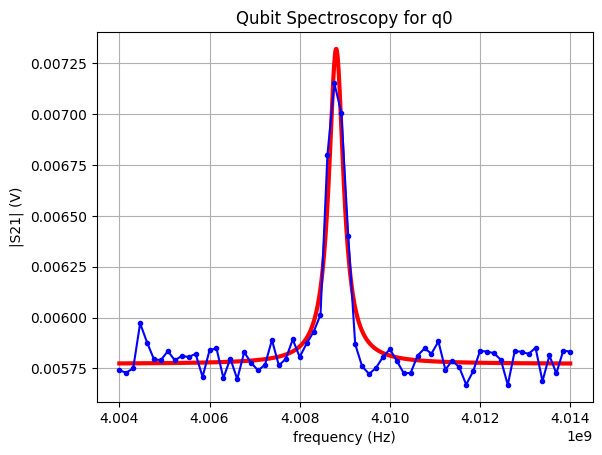

In [2]:
import xarray
import matplotlib.pyplot as plt

# TODO: Replace the file name
ds = xarray.open_dataset('<FILE_YOU_GOT_BY_EMAIL>.hdf5')
analysis = QubitSpectroscopyAnalysis(ds)
fitted_frequency = analysis.run_fitting()

fig, ax = plt.subplots(1, 1)
analysis.plotter(ax, 'q0')
print(f'The qubit frequency is: {fitted_frequency * 10e-10:.3f}GHz')
plt.show()